### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import joblib

#### Load preprocessed dataset

In [2]:
# Load the dataset
data = pd.read_csv('./BackEnd/Credit_score/data/engineered_credit_features.csv')

# Check the dataset to ensure it's loaded correctly
print("First few rows of the dataset:")
display(data.head())
print("\nDataset Info:")
print(data.info())


First few rows of the dataset:


,customer_id,transaction_count,deposit_count,withdrawal_count,avg_transaction_amount,total_deposits,total_withdrawals,days_since_last_transaction,account_utilization,account_age_days,...,payment_consistency,overdraft_usage,loan_count,total_loan_amount,avg_loan_amount,repaid_loans,outstanding_loans,repayment_ratio,loan_to_deposit_ratio,credit_score
0,CustomerId_1,1,0,1,10000.000000,0.0,10000.0,405,1.500000,1,...,0.500000,1.0,2,1255,627.5,0,2,0.0,1255.000000,383.695652
1,CustomerId_10,1,0,1,10000.000000,0.0,10000.0,405,1.500000,1,...,0.500000,1.0,1,2084,2084.0,0,1,0.0,2084.000000,383.695652
2,CustomerId_1001,5,3,2,6080.000000,25200.0,5200.0,410,0.206349,1,...,0.500000,0.0,1,4990,4990.0,0,1,0.0,0.198016,766.304348
3,CustomerId_1002,11,5,6,434.090909,4500.0,275.0,347,0.061111,63,...,-0.917169,0.0,0,0,0.0,0,0,1.0,0.000000,545.108696
4,CustomerId_1003,6,4,2,5333.333333,26000.0,6000.0,333,0.230769,1,...,0.500000,0.0,2,10356,5178.0,0,2,0.0,0.398308,766.304348



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3727 entries, 0 to 3726
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  3727 non-null   object 
 1   transaction_count            3727 non-null   int64  
 2   deposit_count                3727 non-null   int64  
 3   withdrawal_count             3727 non-null   int64  
 4   avg_transaction_amount       3727 non-null   float64
 5   total_deposits               3727 non-null   float64
 6   total_withdrawals            3727 non-null   float64
 7   days_since_last_transaction  3727 non-null   int64  
 8   account_utilization          3727 non-null   float64
 9   account_age_days             3727 non-null   int64  
 10  total_balance                3727 non-null   float64
 11  balance_volatility           3727 non-null   float64
 12  payment_consistency          3727 non-null   float64
 13  ove

#### Train-Test split and normalization

In [3]:
# Drop customer_id as it's not predictive
data = data.drop('customer_id', axis=1)

# Split into features (X) and target (y)
X = data.drop('credit_score', axis=1)
y = data['credit_score']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features for XGBoost and Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest

In [4]:
# --- Random Forest ---
rf = RandomForestRegressor(
        n_estimators=1000, 
        random_state=42,
        max_depth=30
        )
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'\nRandom Forest - MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}')




Random Forest - MSE: 302.3138, RMSE: 17.3872, R²: 0.9878


#### Feature importance on the Random forest model

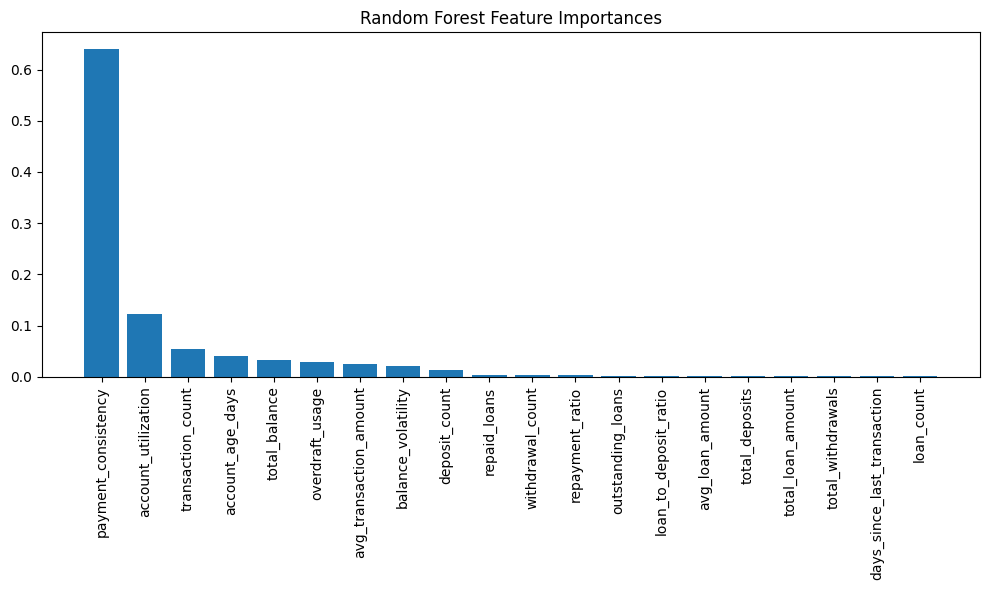

In [5]:
# --- Feature Importance for Random Forest ---
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importances')
plt.bar(range(X.shape[1]), importances_rf[indices_rf])
plt.xticks(range(X.shape[1]), X.columns[indices_rf], rotation=90)
plt.tight_layout()
plt.show()

### XGBoost

In [6]:
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}



xgb = XGBRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    scoring='r2',
    cv=5,
    n_iter=30,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_scaled, y_train)
print("Best Params:", search.best_params_)
print("Best R² Score:", search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best R² Score: 0.9930076661837302


In [7]:
best_xgb = search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"Tuned XGBoost - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2_xgb:.4f}")


Tuned XGBoost - MSE: 182.9731, RMSE: 13.5268, R²: 0.9926


#### feature importance plot on xgoost model

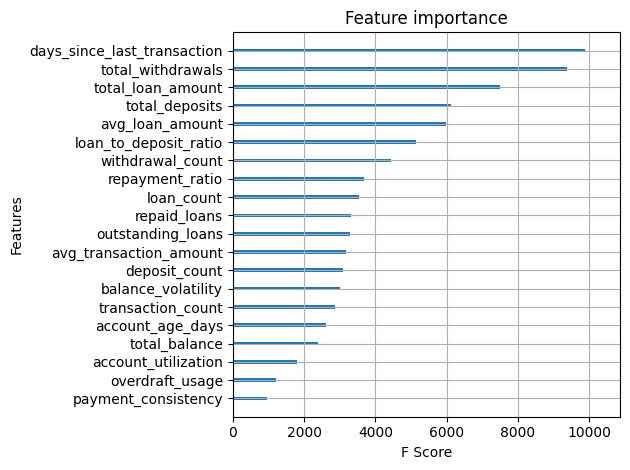

In [8]:
from xgboost import plot_importance

plot_importance(best_xgb, importance_type='weight', xlabel='F Score', ylabel='Features', show_values=False)
plt.yticks(ticks=np.arange(len(X.columns)), labels=X.columns[best_xgb.feature_importances_.argsort()[::-1]])
plt.tight_layout()
plt.show()

#### Cross validation scores

In [9]:
scores = cross_val_score(rf, X_train, y_train, scoring='r2', cv=5)
print(f'Ranom Forest Cross-validated R² mean: {scores.mean():.4f}, std: {scores.std():.4f}')
scores_xgb = cross_val_score(best_xgb, X_train_scaled, y_train, scoring='r2', cv=5)
print(f'XGBoost Cross-validated R² mean: {scores_xgb.mean():.4f}, std: {scores_xgb.std():.4f}')

Ranom Forest Cross-validated R² mean: 0.9878, std: 0.0011
XGBoost Cross-validated R² mean: 0.9930, std: 0.0012


### FFN(Feed Forward Network)

In [10]:
# --- Neural Network ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Linear activation for regression
])

# use Adams optimizer and a mean squared error loss
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
y_pred_nn = model.predict(X_test_scaled).flatten()
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print(f'Neural Network - MSE: {mse_nn:.4f}, RMSE: {rmse_nn:.4f}, R²: {r2_nn:.4f}')

24/24 [==============================] - 0s 1ms/step
Neural Network - MSE: 3345.6805, RMSE: 57.8419, R²: 0.8648


#### FFN Training

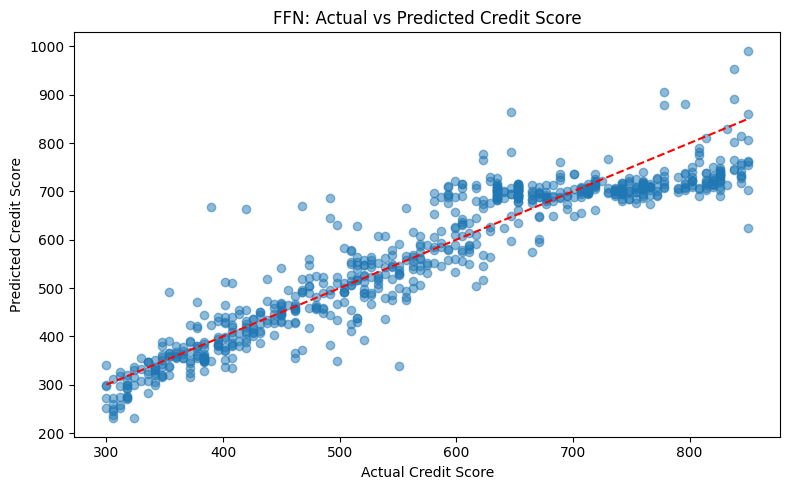

In [16]:
# Plot predicted vs actual credit scores
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Credit Score')
plt.ylabel('Predicted Credit Score')
plt.title('FFN: Actual vs Predicted Credit Score')
plt.tight_layout()
plt.show()

#### Model Performance comparision 

In [12]:
# --- Model Performance Comparison ---
print("\nModel Performance Comparison:")
print(f"Random Forest - R²: {r2_rf:.4f}")
print(f"XGBoost - R²: {r2_xgb:.4f}")
print(f"Neural Network - R²: {r2_nn:.4f}")


Model Performance Comparison:
Random Forest - R²: 0.9878
XGBoost - R²: 0.9926
Neural Network - R²: 0.8648


#### Save models

In [15]:
# Save Random Forest model
joblib.dump(rf, 'trained_models/random_forest_model.pkl')

# Save XGBoost model
joblib.dump(best_xgb, 'trained_models/xgboost_model.pkl')

# Save Neural Network model as pickle (using joblib)
joblib.dump(model, 'trained_models/FFN_model.pkl')

print("Models saved: random_forest_model.pkl, xgboost_model.pkl, FFN_model.pkl")

Models saved: random_forest_model.pkl, xgboost_model.pkl, FFN_model.pkl
